In [49]:
import sys
sys.path.append('../..')

import numpy as np
from collections import OrderedDict

import eeg_decoder

import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
import scipy.stats as sista
from statsmodels.stats.multitest import multipletests

import scipy.io as io
from pathlib import Path


%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
color_palette = {
 'color': 'tab:orange', 
 'ori': 'tab:purple',
 'motion': 'tab:green',
 }

In [3]:
def interpret_results(subtitle, condition_names, condition_order, output_dir, bad_eye_subs=None, stim_time=[0, 500], ylim = [-1, 3], savefig=True, return_time=False):
    interp = eeg_decoder.Interpreter(output_dir=output_dir)
    interp.load_results(subtitle)

    if bad_eye_subs is not None:
        interp.confidence_scores = np.delete(interp.confidence_scores, bad_eye_subs, axis=0)
        interp.confidence_scores_shuff = np.delete(interp.confidence_scores_shuff, bad_eye_subs, axis=0)

    # plot hyperplane results for visual check
    # interp.colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

    interp.plot_hyperplane(
        stim_time=[0,500],
        ylim=[-3,3],stim_label_xy=[130,3.1],label_text_ys=[-1.95,1.95],arrow_ys=[-.5,.5],
        savefig=False,subtitle='Blank',legend_pos='lower left')
    plt.show()
    plt.close()
    

    # get the contrast scores for plotting and testing them
    cond1_diff = interp.confidence_scores[..., 1] - interp.confidence_scores[..., 0]  # SS2_col - SS1_col
    cond1_scores = np.mean(cond1_diff, axis=2)

    cond2_diff = interp.confidence_scores[..., 3] - interp.confidence_scores[..., 2]  # SS2_mot - SS1_mot
    cond2_scores = np.mean(cond2_diff, axis=2)

    cond_scores = [cond1_scores, cond2_scores]
    cond_scores = [cond_scores[i] for i in condition_order]

    # shuffled scores
    cond1_diff_shuff = interp.confidence_scores_shuff[..., 1] - interp.confidence_scores_shuff[..., 0]  # SS2_col - SS1_col
    cond1_scores_shuff = np.mean(cond1_diff_shuff, axis=2)

    cond2_diff_shuff = interp.confidence_scores_shuff[..., 3] - interp.confidence_scores_shuff[..., 2]  # SS2_mot - SS1_mot
    cond2_scores_shuff = np.mean(cond2_diff_shuff, axis=2)

    shuff_scores = [cond1_scores_shuff, cond2_scores_shuff]
    shuff_scores = [shuff_scores[i] for i in condition_order]
    shuff_colors = ['lightgray', 'darkgray']

    # plot the scores
    stim_lower = ylim[0] + 0.01
    stim_upper = ylim[1]

    ax = plt.subplot(111)
    ax.fill_between(
            stim_time, [stim_lower, stim_lower], [stim_upper, stim_upper], color="gray", alpha=0.5
        )

    ax.plot(interp.t, np.zeros((len(interp.t))), "--", color="gray")


    labels = [condition_names[i] for i in condition_order]
    for i, curr_scores in enumerate(cond_scores):

        mean, upper, lower = interp.get_plot_line(shuff_scores[i])
        ax.plot(interp.t, mean, shuff_colors[i], label=labels[i]+' (Shuffled)')
        ax.fill_between(interp.t, upper, lower, color=shuff_colors[i], alpha=0.5)

        mean, upper, lower = interp.get_plot_line(curr_scores)
        ax.plot(interp.t, mean, color_palette[labels[i]], label=labels[i])
        ax.fill_between(interp.t, upper, lower, color=color_palette[labels[i]], alpha=0.5)

        _, ps = sista.ttest_rel(curr_scores, shuff_scores[i], axis=0, alternative="greater")
        _, corrected_p, _, _ = multipletests(ps, method="fdr_bh")
        sig05 = corrected_p < 0.05
        plt.scatter(
            interp.t[sig05],
            np.ones(sum(sig05))*-.2*(i+1)-.3,
            marker="s",
            s=33,
            c=color_palette[labels[i]]
        )

    # compare the two
    __, ps = sista.ttest_rel(cond_scores[0]-cond_scores[1], shuff_scores[0]-shuff_scores[1], axis=0, alternative="greater")
    _, corrected_p, _, _ = multipletests(ps, method="fdr_bh")
    sig05 = corrected_p < 0.05
    if sum(sig05) > 0:
        _ = plt.scatter(
            interp.t[sig05],
            np.ones(sum(sig05))*-.9,
            marker="s",
            s=33,
            c="k",
        )
    else:
        print("no significant differences between conditions")

    plt.title(f'Hyperplane contrast: {subtitle}')
    _ = plt.legend()
    sns.despine()
    if savefig:
        plt.savefig(f'./figures/{subtitle}_hyperplane.svg')
    plt.show()
    plt.close()
    if return_time:
        return cond1_diff, cond2_diff, interp.t
    else:
        return cond1_diff, cond2_diff

In [4]:
experiments = ['boomerang', 'eggtoss']

conditions_per_experiment = {
    'boomerang': ('color', 'ori'),
    'eggtoss': ('color', 'motion'),
}

bad_eyes_per_experiment = {
    'boomerang': [],
    'eggtoss': [14]
}

experiments_window_starts = {
    'boomerang': 750,
    'eggtoss': 1000,
}

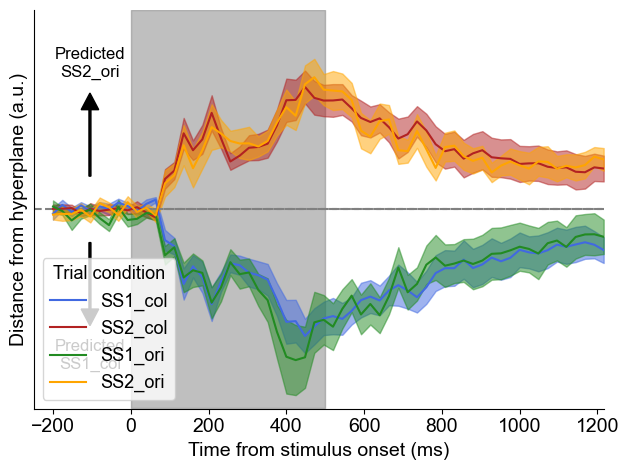

no significant differences between conditions


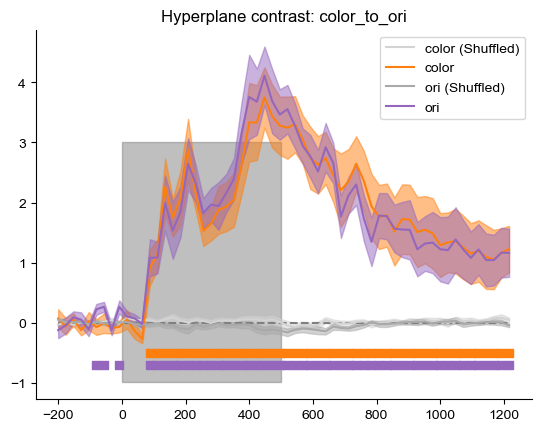

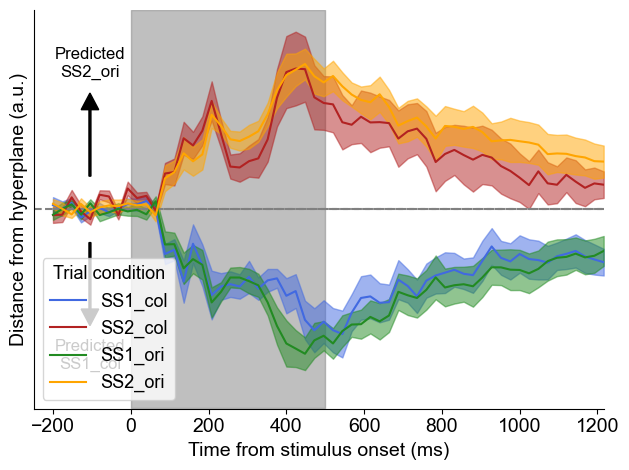

no significant differences between conditions


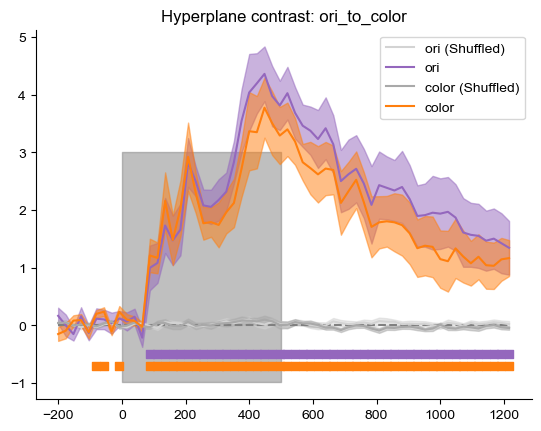

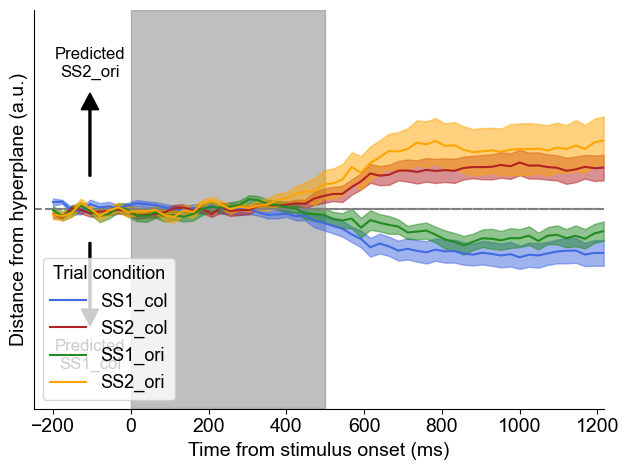

no significant differences between conditions


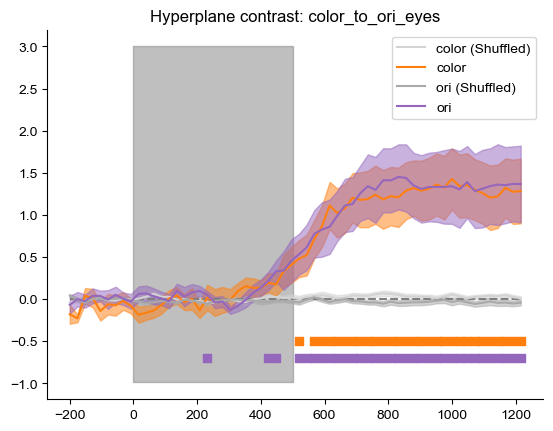

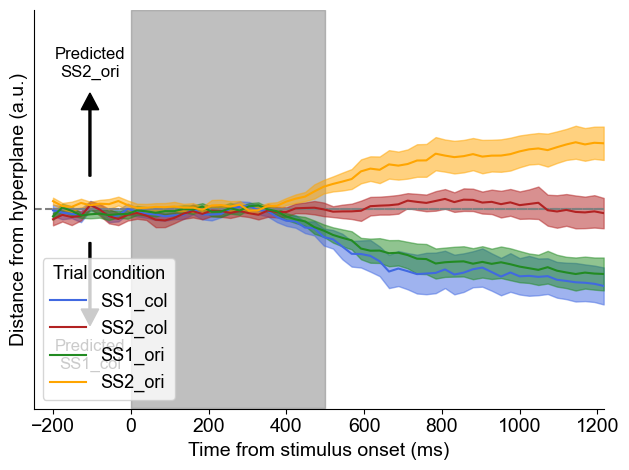

no significant differences between conditions


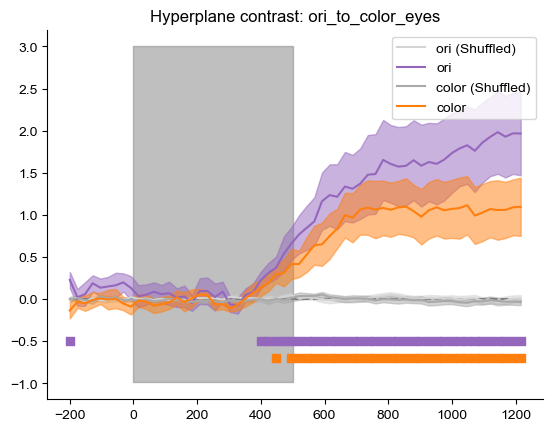

20


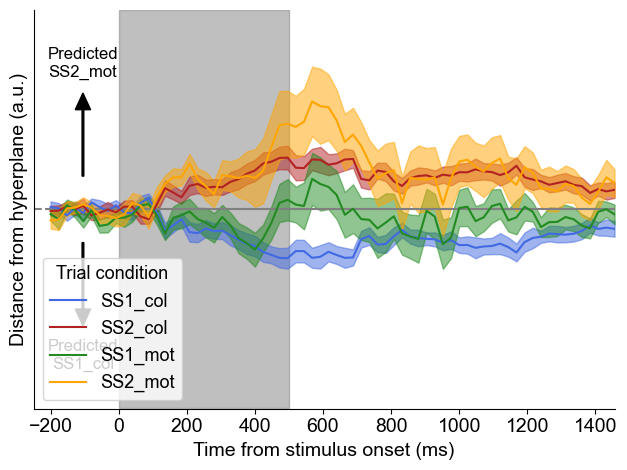

no significant differences between conditions


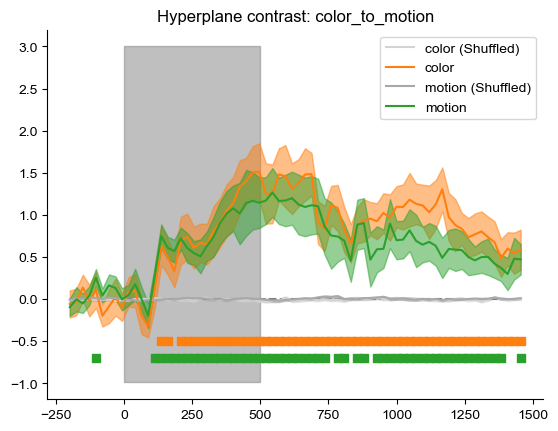

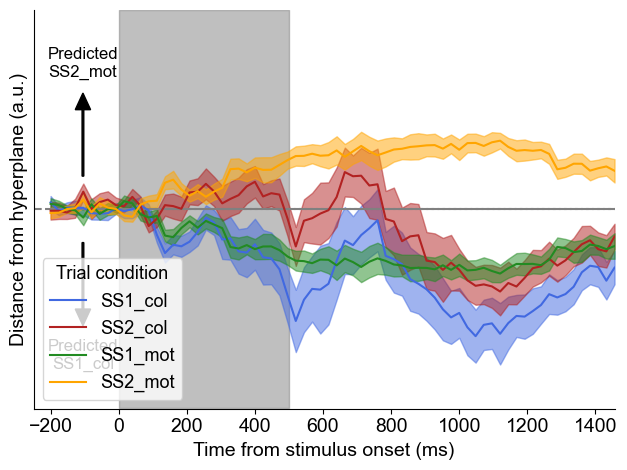

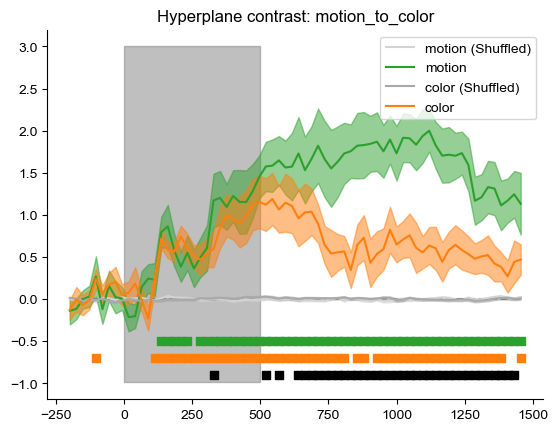

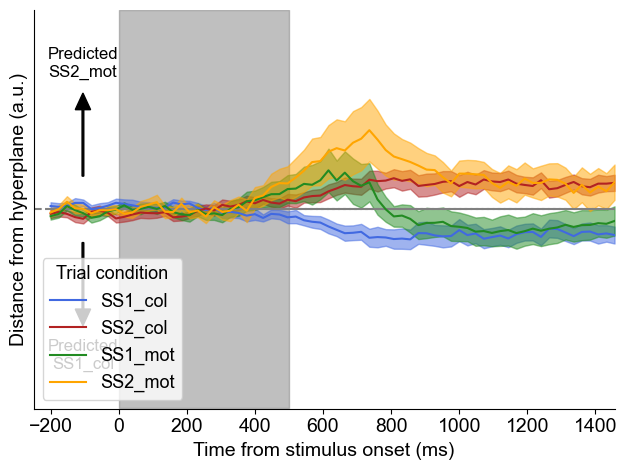

no significant differences between conditions


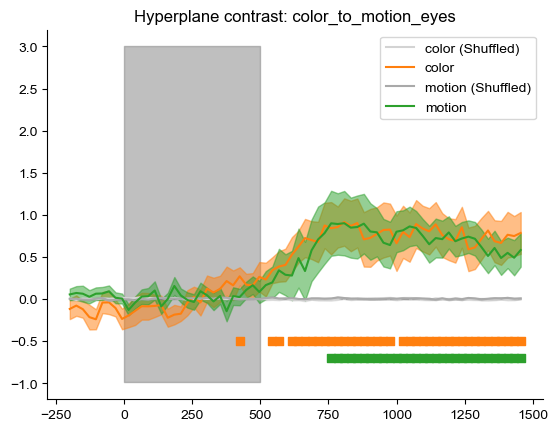

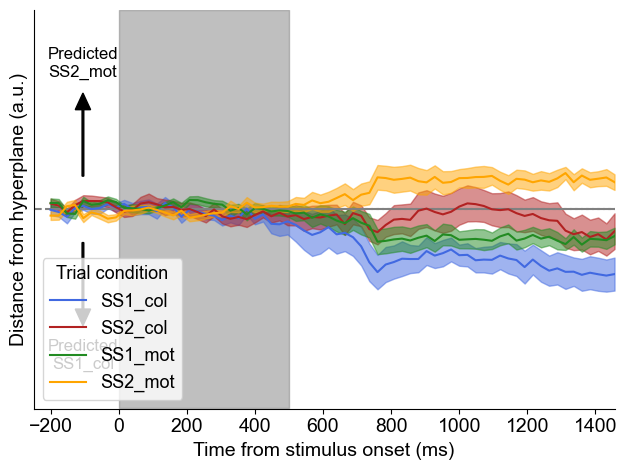

no significant differences between conditions


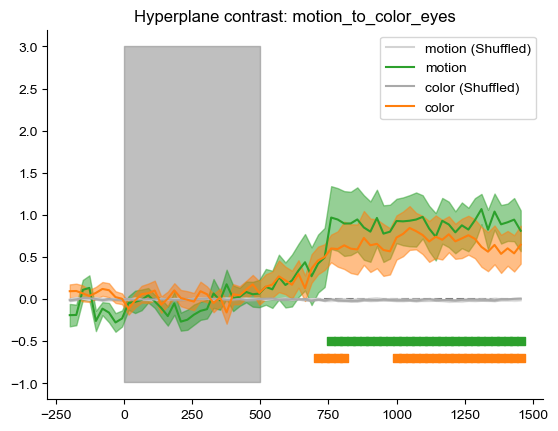

20


In [5]:
full_df = pd.DataFrame()
for experiment in experiments:
    cond1, cond2 = conditions_per_experiment[experiment]
    bad_eye_subs = bad_eyes_per_experiment[experiment]

    window_start = experiments_window_starts[experiment]

    _, cond1_to_cond2, times = interpret_results(f'{cond1}_to_{cond2}', [cond1, cond2], output_dir=Path(f'{experiment}/analysis/output'), condition_order=[0,1], bad_eye_subs=bad_eye_subs, savefig=False, return_time=True)
    _, cond2_to_cond1 = interpret_results(f'{cond2}_to_{cond1}', [cond1, cond2], output_dir=Path(f'{experiment}/analysis/output'), condition_order=[1,0], bad_eye_subs=bad_eye_subs, savefig=False)

    _, cond1_to_cond2_eyes = interpret_results(f'{cond1}_to_{cond2}_eyes', [cond1, cond2], output_dir=Path(f'{experiment}/analysis/output'), condition_order=[0,1], bad_eye_subs=bad_eye_subs, savefig=False)
    _, cond2_to_cond1_eyes = interpret_results(f'{cond2}_to_{cond1}_eyes', [cond1, cond2], output_dir=Path(f'{experiment}/analysis/output'), condition_order=[1,0], bad_eye_subs=bad_eye_subs, savefig=False)

    # average across permutations per model
    # average across generlization directions
    # average across last 500ms of delay period
    eeg_generalize = np.concatenate([cond1_to_cond2.mean(-1)[np.newaxis, ...], cond2_to_cond1.mean(-1)[np.newaxis, ...]])
    eeg_generalize = eeg_generalize.mean(0)
    eeg_generalize = eeg_generalize[:, times>=window_start].mean(axis=1)

    

    eye_generalize = np.concatenate([cond1_to_cond2_eyes.mean(-1)[np.newaxis, ...], cond2_to_cond1_eyes.mean(-1)[np.newaxis, ...]])
    eye_generalize = eye_generalize.mean(0)
    eye_generalize = eye_generalize[:, times>=window_start].mean(axis=1)

    experiment_df = pd.DataFrame({'eeg_decoding': eeg_generalize, 'eye_decoding': eye_generalize, 'experiment': experiment, 'subid': np.arange(eeg_generalize.shape[0])})
    full_df = full_df.append(experiment_df)


    print(np.sum(times>=window_start))

# Full model

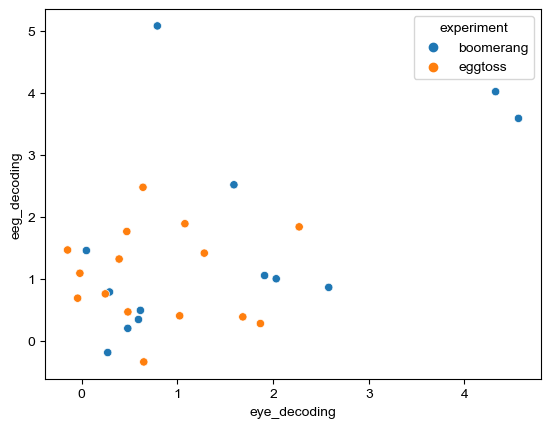

In [6]:
_ = sns.scatterplot(data=full_df, x='eye_decoding', y='eeg_decoding', hue='experiment')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           eeg_decoding   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     3.616
Date:                Mon, 15 Jul 2024   Prob (F-statistic):             0.0417
Time:                        11:29:50   Log-Likelihood:                -42.168
No. Observations:                  28   AIC:                             90.34
Df Residuals:                      25   BIC:                             94.33
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
eye_decoding        0.4612      0.196      2.351      0.027       0.057       0.865
eggtoss_const       0.6948      0.336      2.067      0.049       0.002       1.387
boomerang_const     0.9184      0.441      2.082      0.048       0.010       1.827
==============================================================================
Omnibus:                       15.246   Durbin-Watson:                   2.156
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.572
Skew:                           1.345   Prob(JB):                     0.000153
Kurtosis:                       5.797   Cond. No.                         3.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

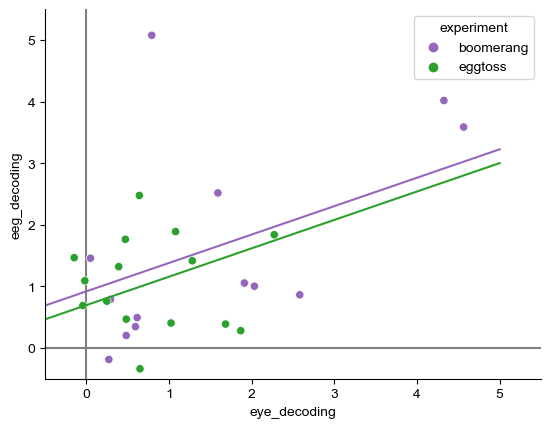

In [50]:
import statsmodels.api as sm

#define response variable
y = full_df['eeg_decoding']

#define explanatory variable
x = pd.DataFrame(full_df['eye_decoding'])

# #add constant to predictor variables
# x = sm.add_constant(x)

#add  intercepts for both experiments
x['eggtoss_const'] = 0
x.loc[full_df['experiment'] == 'eggtoss', 'eggtoss_const'] = 1

x['boomerang_const'] = 0
x.loc[full_df['experiment'] == 'boomerang', 'boomerang_const'] = 1

#fit linear regression model
model = sm.OLS(y, x).fit()

palette = {
    'boomerang': 'tab:purple',
    'eggtoss': 'tab:green'

}


# replot with the added lines from the model
_ = sns.scatterplot(data=full_df, x='eye_decoding', y='eeg_decoding', hue='experiment', palette=palette)
plt.plot([-.5, 5], model.predict(np.array([[-.5, 5], [0, 0], [1, 1]]).T), 'tab:purple')
_ = plt.plot([-.5, 5], model.predict(np.array([[-.5, 5], [1, 1], [0, 0]]).T), 'tab:green')
# add horizontal and vertical lines to show the intercepts
plt.axhline(0, color='gray', linestyle='-', zorder=-1)
plt.axvline(0, color='gray', linestyle='-', zorder=-1)
plt.xlim(-.5, 5.5)
plt.ylim(-.5, 5.5)
_ = sns.despine()
plt.savefig('eye_comparisons.svg')
model.summary()

In [21]:
x_sorted['eye_decoding'][egg_index]

11    0.049549
11    0.648942
3     0.272146
3     1.078767
10    0.291190
10    1.024144
1     0.481968
1     1.867683
2    -0.042194
2     0.593650
4     0.483004
4     0.613952
5     0.790974
5     1.683748
0    -0.147206
0     1.590929
9     0.640786
9     1.911240
7     1.281384
7     2.032944
12   -0.018490
12    2.581466
8     2.272656
8     4.325127
6     0.247193
6     4.564037
Name: eye_decoding, dtype: float64

# Remove those 2 outliers

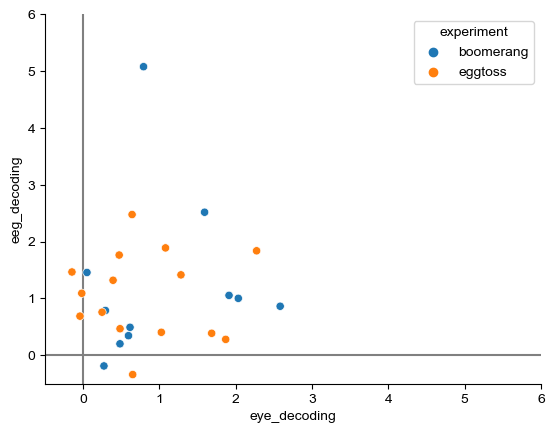

In [38]:
strong_points = [6, 8]
bad_idx = full_df.index.isin(strong_points) & (full_df['experiment'] == 'boomerang')
trimmed_df = full_df[~bad_idx]

_ = sns.scatterplot(data=trimmed_df, x='eye_decoding', y='eeg_decoding', hue='experiment')
plt.axhline(0, color='gray', linestyle='-', zorder=-1)
plt.axvline(0, color='gray', linestyle='-', zorder=-1)
plt.xlim(-.5, 6)
plt.ylim(-.5, 6)
_ = sns.despine()


In [9]:
import statsmodels.api as sm

#define response variable
y = trimmed_df['eeg_decoding']

#define explanatory variable
x = pd.DataFrame(trimmed_df['eye_decoding'])

#add constant intercepts for both experiments
x['eggtoss_const'] = 0
x.loc[trimmed_df['experiment'] == 'eggtoss', 'eggtoss_const'] = 1

x['boomerang_const'] = 0
x.loc[trimmed_df['experiment'] == 'boomerang', 'boomerang_const'] = 1

#fit linear regression model
model = sm.OLS(y, x).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           eeg_decoding   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.076
Method:                 Least Squares   F-statistic:                    0.1136
Date:                Mon, 15 Jul 2024   Prob (F-statistic):              0.893
Time:                        10:57:29   Log-Likelihood:                -38.482
No. Observations:                  26   AIC:                             82.96
Df Residuals:                      23   BIC:                             86.74
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
eye_decoding        0.0789      0.294      0.268      0.791      -0.530       0.687
eggtoss_const       0.9976      0.373      2.671      0.014       0.225       1.770
boomerang_const     1.1565      0.454      2.548      0.018       0.218       2.095
==============================================================================
Omnibus:                       21.418   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.273
Skew:                           1.746   Prob(JB):                     9.82e-08
Kurtosis:                       7.195   Cond. No.                         3.26
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# remove all  outliers

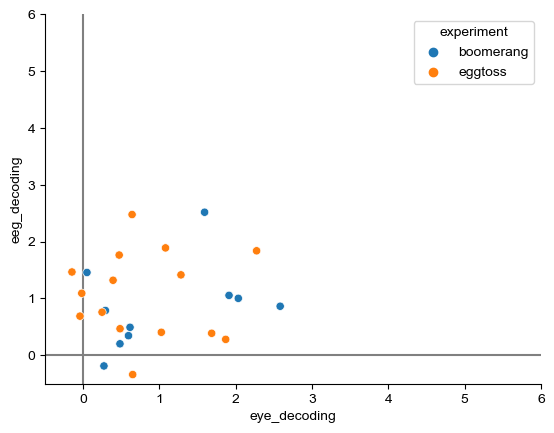

In [39]:
strong_points = [5, 6, 8]
bad_idx = full_df.index.isin(strong_points) & (full_df['experiment'] == 'boomerang')
trimmed_df = full_df[~bad_idx]

_ = sns.scatterplot(data=trimmed_df, x='eye_decoding', y='eeg_decoding', hue='experiment')
plt.axhline(0, color='gray', linestyle='-', zorder=-1)
plt.axvline(0, color='gray', linestyle='-', zorder=-1)
plt.xlim(-.5, 6)
plt.ylim(-.5, 6)
_ = sns.despine()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           eeg_decoding   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                 -0.045
Method:                 Least Squares   F-statistic:                    0.4798
Date:                Mon, 15 Jul 2024   Prob (F-statistic):              0.625
Time:                        11:25:28   Log-Likelihood:                -27.258
No. Observations:                  25   AIC:                             60.52
Df Residuals:                      22   BIC:                             64.17
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
eye_decoding        0.1447      0.200      0.723      0.477      -0.270       0.560
eggtoss_const       0.9455      0.254      3.725      0.001       0.419       1.472
boomerang_const     0.7023      0.320      2.195      0.039       0.039       1.366
==============================================================================
Omnibus:                        0.636   Durbin-Watson:                   1.691
Prob(Omnibus):                  0.728   Jarque-Bera (JB):                0.584
Skew:                           0.330   Prob(JB):                        0.747
Kurtosis:                       2.647   Cond. No.                         3.28
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

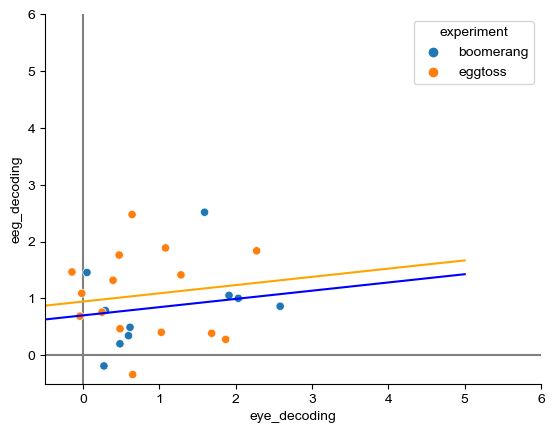

In [44]:
import statsmodels.api as sm

#define response variable
y = trimmed_df['eeg_decoding']

#define explanatory variable
x = pd.DataFrame(trimmed_df['eye_decoding'])

#add constant intercepts for both experiments
x['eggtoss_const'] = 0
x.loc[trimmed_df['experiment'] == 'eggtoss', 'eggtoss_const'] = 1

x['boomerang_const'] = 0
x.loc[trimmed_df['experiment'] == 'boomerang', 'boomerang_const'] = 1

#fit linear regression model
model = sm.OLS(y, x).fit()

model.summary()


# replot with the added lines from the model
_ = sns.scatterplot(data=trimmed_df, x='eye_decoding', y='eeg_decoding', hue='experiment')
plt.plot([-.5, 5], model.predict(np.array([[-.5, 5], [0, 0], [1, 1]]).T), 'blue')
_ = plt.plot([-.5, 5], model.predict(np.array([[-.5, 5], [1, 1], [0, 0]]).T), 'orange')
# add horizontal and vertical lines to show the intercepts
plt.axhline(0, color='gray', linestyle='-', zorder=-1)
plt.axvline(0, color='gray', linestyle='-', zorder=-1)
plt.xlim(-.5, 6)
plt.ylim(-.5, 6)
_ = sns.despine()
model.summary()

# Rerun load models without problematic subs

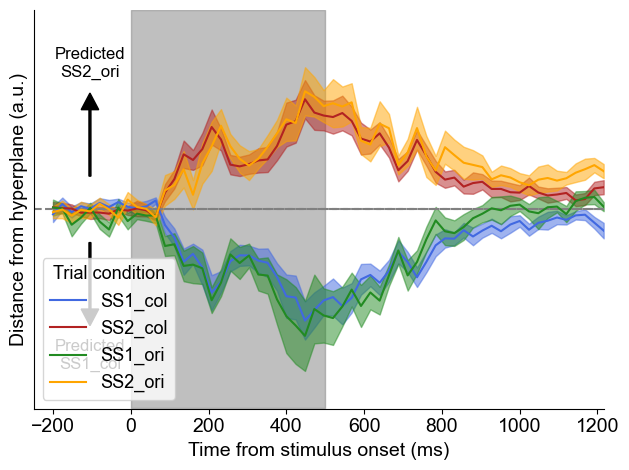

no significant differences between conditions


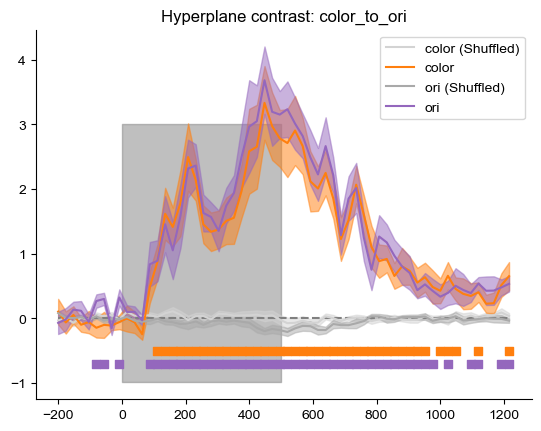

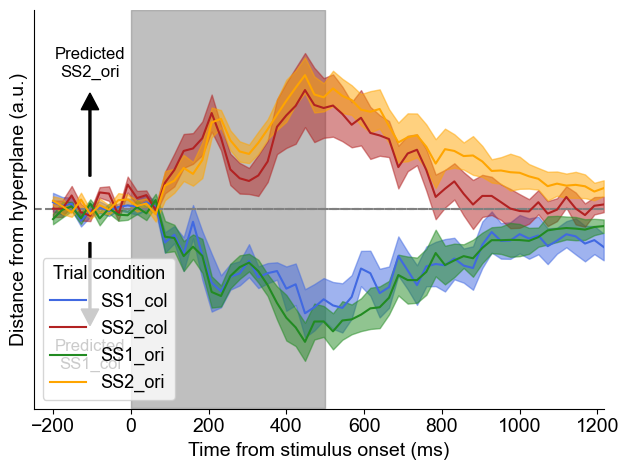

no significant differences between conditions


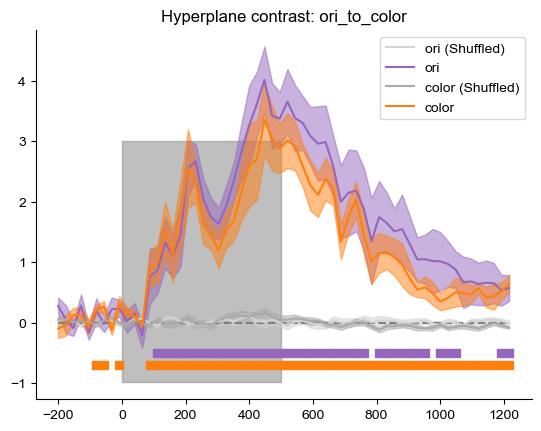

In [13]:
strong_points = [5, 6, 8]

_ = interpret_results(f'color_to_ori', ['color', 'ori'], output_dir=Path(f'boomerang/analysis/output'), condition_order=[0,1], bad_eye_subs=strong_points, savefig=False)
_ = interpret_results(f'ori_to_color', ['color', 'ori'], output_dir=Path('boomerang/analysis/output'), condition_order=[1,0], bad_eye_subs=strong_points, savefig=False)